In [1]:
!pip install torch torchvision
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00


In [5]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import FacebookPagePage
from torch_geometric.utils import degree
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.datasets import Amazon

In [6]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true).item() / len(y_true)

In [11]:
# Import dataset from PyTorch Geometric
dataset = Amazon(root=".", name="Computers")
# Access the first data instance
data = dataset[0]

In [12]:
# Create masks
data.train_mask = range(11000)
data.val_mask = range(11001, 12000)
data.test_mask = range(12001, 13752)

In [13]:
# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

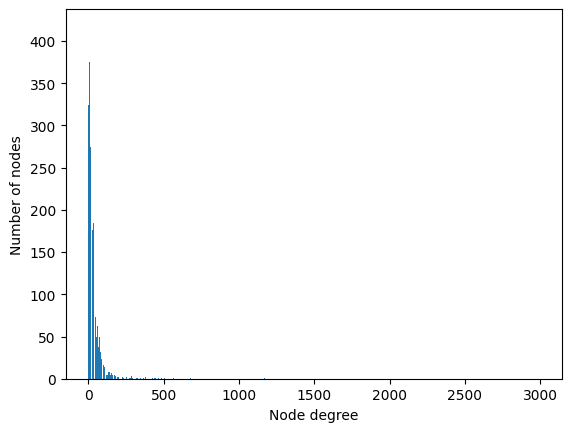

In [14]:
# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())
plt.show()

In [15]:
# Build GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs=100, lr=0.01):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = self.forward(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            train_pred = out[data.train_mask].argmax(dim=1)
            train_acc = accuracy(train_pred, data.y[data.train_mask])

            # Calculate validation accuracy
            val_pred = out[data.val_mask].argmax(dim=1)
            val_acc = accuracy(val_pred, data.y[data.val_mask])

            if epoch % 10 == 0:
                print(f"Epoch {epoch:3d} | Train Loss: {loss.item():.4f} | Train Acc: {train_acc*100:.2f}% | "
                      f"Val Loss: {loss.item():.4f} | Val Acc: {val_acc*100:.2f}%")

    def test(self, data):
        self.eval()
        with torch.no_grad():
            logits = self.forward(data)
            pred = logits.argmax(dim=1)
            # Calculate test accuracy
            acc = accuracy(pred[data.test_mask], data.y[data.test_mask])
            return acc


In [16]:
# Train GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (conv1): GCNConv(767, 16)
  (conv2): GCNConv(16, 10)
)
Epoch   0 | Train Loss: 2.6668 | Train Acc: 5.91% | Val Loss: 2.6668 | Val Acc: 6.51%
Epoch  10 | Train Loss: 1.7494 | Train Acc: 50.65% | Val Loss: 1.7494 | Val Acc: 50.45%
Epoch  20 | Train Loss: 1.5082 | Train Acc: 51.46% | Val Loss: 1.5082 | Val Acc: 49.15%
Epoch  30 | Train Loss: 1.3056 | Train Acc: 58.71% | Val Loss: 1.3056 | Val Acc: 58.46%
Epoch  40 | Train Loss: 1.1566 | Train Acc: 66.80% | Val Loss: 1.1566 | Val Acc: 66.27%
Epoch  50 | Train Loss: 1.0101 | Train Acc: 71.95% | Val Loss: 1.0101 | Val Acc: 69.87%
Epoch  60 | Train Loss: 0.8752 | Train Acc: 73.92% | Val Loss: 0.8752 | Val Acc: 71.87%
Epoch  70 | Train Loss: 0.7643 | Train Acc: 80.54% | Val Loss: 0.7643 | Val Acc: 79.88%
Epoch  80 | Train Loss: 0.6362 | Train Acc: 81.99% | Val Loss: 0.6362 | Val Acc: 81.68%
Epoch  90 | Train Loss: 0.5533 | Train Acc: 84.51% | Val Loss: 0.5533 | Val Acc: 84.78%

GCN test accuracy: 84.35%



In [17]:
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=0.5)  # Añadir dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs=200, lr=0.005, patience=10):
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=5e-4)
        best_val_acc = 0
        epochs_without_improvement = 0
        best_model_state = None

        self.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = self.forward(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            # Calcular accuracy en entrenamiento
            train_pred = out[data.train_mask].argmax(dim=1)
            train_acc = accuracy(train_pred, data.y[data.train_mask])

            # Calcular accuracy en validación
            val_pred = out[data.val_mask].argmax(dim=1)
            val_acc = accuracy(val_pred, data.y[data.val_mask])

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_without_improvement = 0
                best_model_state = self.state_dict()  # Guardar mejor estado del modelo
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement == patience:
                print(f"Early stopping at epoch {epoch} with best validation accuracy: {best_val_acc*100:.2f}%")
                break

            if epoch % 10 == 0:
                print(f"Epoch {epoch:3d} | Train Loss: {loss.item():.4f} | Train Acc: {train_acc*100:.2f}% | "
                      f"Val Loss: {loss.item():.4f} | Val Acc: {val_acc*100:.2f}%")

        # Cargar el mejor estado del modelo
        if best_model_state is not None:
            self.load_state_dict(best_model_state)

    def test(self, data):
        self.eval()
        with torch.no_grad():
            logits = self.forward(data)
            pred = logits.argmax(dim=1)
            acc = accuracy(pred[data.test_mask], data.y[data.test_mask])
            return acc

In [18]:
# Inicializar y entrenar el modelo
gcn = GCN(dataset.num_features, 32, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=200, lr=0.005, patience=10)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (conv1): GCNConv(767, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 10)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch   0 | Train Loss: 2.4444 | Train Acc: 3.61% | Val Loss: 2.4444 | Val Acc: 3.40%
Epoch  10 | Train Loss: 1.8566 | Train Acc: 41.11% | Val Loss: 1.8566 | Val Acc: 40.04%
Epoch  20 | Train Loss: 1.4919 | Train Acc: 61.51% | Val Loss: 1.4919 | Val Acc: 59.46%
Epoch  30 | Train Loss: 1.2054 | Train Acc: 65.32% | Val Loss: 1.2054 | Val Acc: 64.56%
Epoch  40 | Train Loss: 0.9799 | Train Acc: 70.94% | Val Loss: 0.9799 | Val Acc: 70.07%
Epoch  50 | Train Loss: 0.8165 | Train Acc: 75.62% | Val Loss: 0.8165 | Val Acc: 75.68%
Epoch  60 | Train Loss: 0.7069 | Train Acc: 78.45% | Val Loss: 0.7069 | Val Acc: 77.28%
Epoch  70 | Train Loss: 0.6364 | Train Acc: 80.57% | Val Loss: 0.6364 | Val Acc: 78.78%
Epoch  80 | Train Loss: 0.6111 | Train Acc: 81.94% | Val Loss: 0.6111 | Val Acc: 82.08%
Epoch  90 | Train Loss: 0.5665 | Train Acc: 83.27% | Val Loss: 0.5665 | Val Ac